#### Importamos las librerías

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Almacenamos nuestra tabla en un Dataframe

In [316]:
# Importamos el dataframe con la columna "deposit" incluida
df_bank = pd.read_csv("perfil_cliente_mysql.csv", delimiter=";")

# Creamos un segundo dataframe sin la columna "deposit" para el algoritmo
df_kmeans = df_bank.drop(columns=["deposit"])

#### Vamos a convertir las categorías de trabajo en 3 subgrupos: Profesional, Manual y Otro

In [317]:
job_mapping = {
    "admin": "profesional",
    "technician": "profesional",
    "management": "profesional",
    "entrepreneur": "profesional",
    "self-employed": "profesional",
    "blue-collar": "manual",
    "services": "manual",
    "housemaid": "manual",
    "retired": "otro",
    "unemployed": "otro",
    "student": "otro",
    "unknown": "otro"
}

df_kmeans['job'] = df_kmeans['job'].replace(job_mapping)

print(df_kmeans['job'].value_counts())

job
profesional    9372
manual         4525
otro           2266
Name: count, dtype: int64


#### Preprocesamiento variables categóricas

In [318]:
categorical_features = ["job", "marital", "education", "housing"]

label_encoders = {}

for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    
    df_kmeans[feature + "_encoded"] = label_encoders[feature].fit_transform(df_kmeans[feature])

df_kmeans = df_kmeans.drop(columns=categorical_features, axis=1)

df_kmeans

,age,balance,job_encoded,marital_encoded,education_encoded,housing_encoded
0,59,2343,2,1,1,1
1,59,2343,2,1,1,1
2,56,45,2,1,1,0
3,41,1270,2,1,1,1
4,55,2476,0,1,1,1
...,...,...,...,...,...,...
16158,26,1595,2,1,1,0
16159,37,1967,2,1,1,0
16160,45,81,2,1,2,0
16161,44,618,0,2,1,0


#### Preprocesamiento variables numéricas

<Figure size 800x500 with 0 Axes>

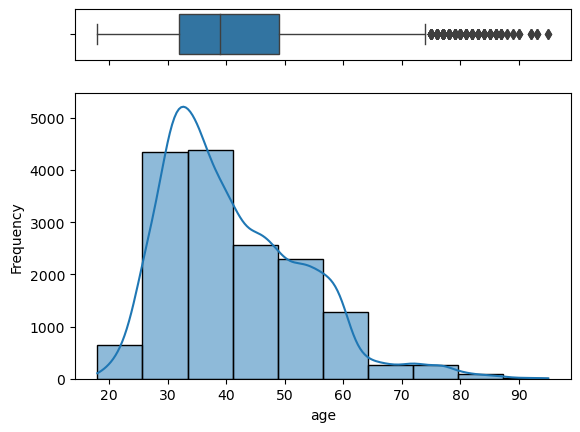

<Figure size 800x500 with 0 Axes>

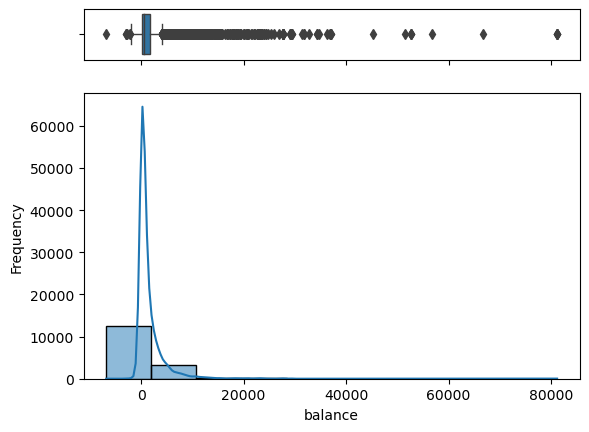

In [319]:
numerical_features = ["age", "balance"]

for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    

    sns.boxplot(x=df_kmeans[i], orient="h", ax=ax_box, linewidth=1.0)
    
    sns.histplot(df_kmeans[i], ax=ax_hist, bins=10, kde=True)
    
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

#### Como las variables tienen outliers, vamos a utilizar los límites superiores e inferiores del IQR para reemplazarlos.

In [320]:
def percentile_calculation(df, column):
    percentile_75 = df[column].quantile(0.75)
    percentile_25 = df[column].quantile(0.25)
    IQR = percentile_75 - percentile_25
    upper_limit = percentile_75 + (1.5 * IQR)
    lower_limit = percentile_25 - (1.5 * IQR)
    return upper_limit, lower_limit

def winsorize_percentile(df, column):
    upper_limit, lower_limit = percentile_calculation(df, column)

    print(f'upper limit de {column}: {upper_limit}')
    print(f'lower limit de {column}: {lower_limit}')
    
    df[column] = np.where(df[column] > upper_limit, upper_limit,
                          np.where(df[column] < lower_limit, lower_limit, df[column]))
    return df


for i in numerical_features:
    df_kmeans = winsorize_percentile(df_kmeans, i)


upper limit de age: 74.5
lower limit de age: 6.5
upper limit de balance: 4108.0
lower limit de balance: -2268.0


<Figure size 800x500 with 0 Axes>

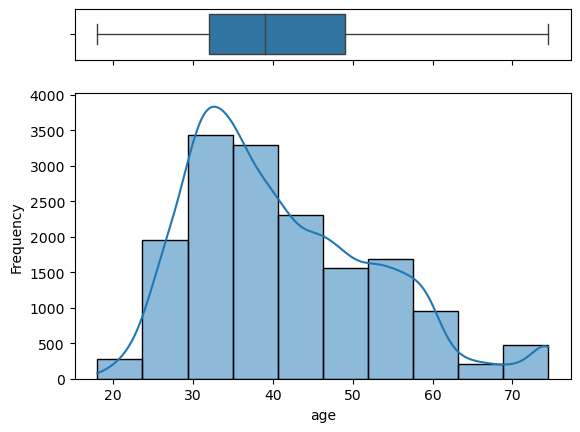

<Figure size 800x500 with 0 Axes>

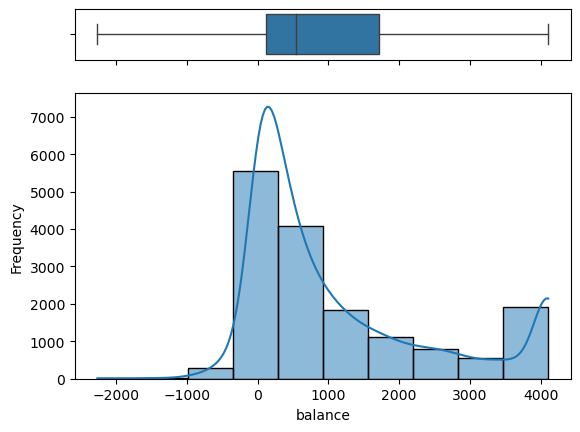

In [321]:
for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(x=df_kmeans[i], orient="h", ax=ax_box, linewidth=1.0)
    
    sns.histplot(df_kmeans[i], ax=ax_hist, bins=10, kde=True)
    
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

In [322]:
scaler = StandardScaler()

df_kmeans[numerical_features] = scaler.fit_transform(df_kmeans[numerical_features])

df_kmeans

,age,balance,job_encoded,marital_encoded,education_encoded,housing_encoded
0,1.523529,0.902923,2,1,1,1
1,1.523529,0.902923,2,1,1,1
2,1.267015,-0.793012,2,1,1,0
3,-0.015556,0.111044,2,1,1,1
4,1.181510,1.001078,0,1,1,1
...,...,...,...,...,...,...
16158,-1.298126,0.350896,2,1,1,0
16159,-0.357574,0.625434,2,1,1,0
16160,0.326463,-0.766444,2,1,2,0
16161,0.240958,-0.370135,0,2,1,0


#### Luego de estandarizar, veamos la distribución con media 0 y desviación estándar de 1.

<Figure size 800x500 with 0 Axes>

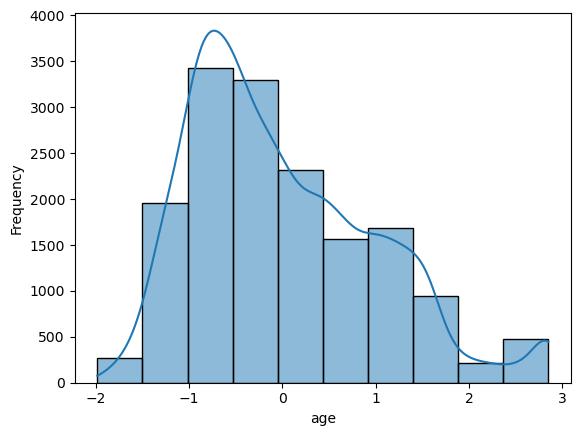

<Figure size 800x500 with 0 Axes>

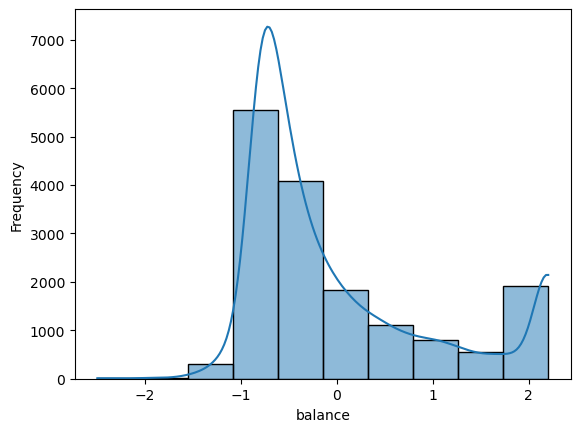

In [323]:
for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    f, ax = plt.subplots(sharex=True)

    sns.histplot(df_kmeans[i], bins=10, kde=True)
    
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

#### Identificamos el número de clusters

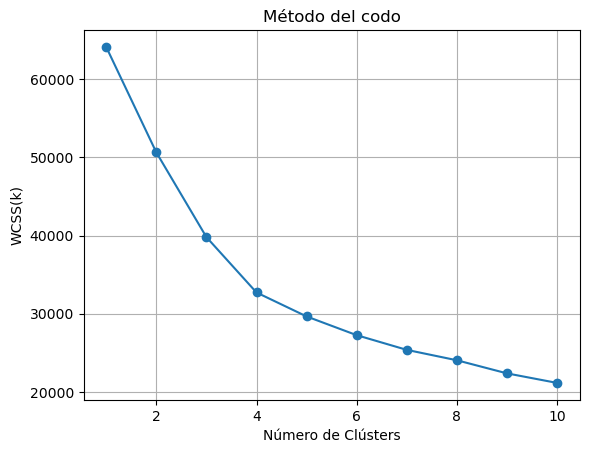

In [324]:
# Lista para almacenar la inercia para cada K
wcss = []

for i in range(1, 11):

    kmeans = KMeans(n_clusters = i, 
                    init = "k-means++", 
                    max_iter = 300, 
                    n_init = 10, 
                    random_state = 42)

    kmeans.fit(df_kmeans) 
    
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss, marker='o')
plt.title("Método del codo")
plt.xlabel("Número de Clústers")
plt.ylabel("WCSS(k)")
plt.grid(True)
plt.show()

#### Ejecutamos el algoritmo de K-Means con 4 clusters

In [325]:
kmeans = KMeans(n_clusters = 4, 
                init="k-means++", 
                max_iter = 100, 
                n_init = 10, 
                random_state = 42)
           
df_kmeans['cluster'] = kmeans.fit_predict(df_kmeans)

In [326]:
score = silhouette_score(df_kmeans, df_kmeans['cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.3615378192707164


In [329]:
df_kmeans

,age,balance,job_encoded,marital_encoded,education_encoded,housing_encoded,cluster,job_original
0,1.523529,0.902923,2,1,1,1,0,profesional
1,1.523529,0.902923,2,1,1,1,0,profesional
2,1.267015,-0.793012,2,1,1,0,0,profesional
3,-0.015556,0.111044,2,1,1,1,2,profesional
4,1.181510,1.001078,0,1,1,1,1,manual
...,...,...,...,...,...,...,...,...
16158,-1.298126,0.350896,2,1,1,0,2,profesional
16159,-0.357574,0.625434,2,1,1,0,2,profesional
16160,0.326463,-0.766444,2,1,2,0,2,profesional
16161,0.240958,-0.370135,0,2,1,0,1,manual


In [331]:
# Recodificamos las variables categóricas
for feature in categorical_features:
    df_kmeans[feature + "_original"] = label_encoders[feature].inverse_transform(df_kmeans[feature + "_encoded"])
    df_kmeans = df_kmeans.drop(columns= feature + "_encoded")

# Para poder unificar con la tabla original, cambiamos el título de las columnas age y balance
df_kmeans = df_kmeans.rename(columns={"age": "age_kmeans", "balance": "balance_kmeans"})

# Y luego realizamos un join a través del índice

df_results = df_kmeans.join(df_bank)

df_results

,age_kmeans,balance_kmeans,cluster,job_original,marital_original,education_original,housing_original,age,job,marital,education,balance,housing,deposit
0,1.523529,0.902923,0,profesional,married,secondary,yes,59,admin,married,secondary,2343,yes,yes
1,1.523529,0.902923,0,profesional,married,secondary,yes,59,admin,married,secondary,2343,yes,yes
2,1.267015,-0.793012,0,profesional,married,secondary,no,56,admin,married,secondary,45,no,yes
3,-0.015556,0.111044,2,profesional,married,secondary,yes,41,technician,married,secondary,1270,yes,yes
4,1.181510,1.001078,1,manual,married,secondary,yes,55,services,married,secondary,2476,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16158,-1.298126,0.350896,2,profesional,married,secondary,no,26,admin,married,secondary,1595,no,yes
16159,-0.357574,0.625434,2,profesional,married,secondary,no,37,admin,married,secondary,1967,no,yes
16160,0.326463,-0.766444,2,profesional,married,tertiary,no,45,management,married,tertiary,81,no,no
16161,0.240958,-0.370135,1,manual,single,secondary,no,44,services,single,secondary,618,no,yes


#### Visualizamos los clusters creados en un mismo scatterplot

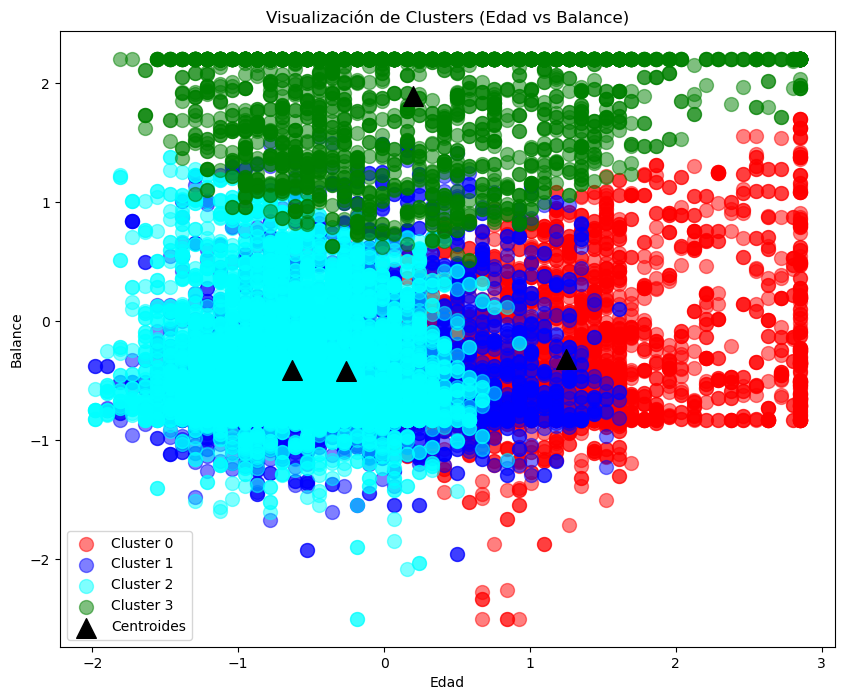

In [333]:
plt.figure(figsize=(10, 8))

colors = ['red', 'blue', 'cyan', 'green']

for i in range(4):
    plt.scatter(df_kmeans.loc[df_kmeans['cluster'] == i, 'age_kmeans'], 
                df_kmeans.loc[df_kmeans['cluster'] == i, 'balance_kmeans'], 
                s = 100, c = colors[i], label = f'Cluster {i}', alpha=0.5)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s = 200, c = 'black', marker='^', label='Centroides')

plt.title('Visualización de Clusters (Edad vs Balance)')
plt.xlabel('Edad')
plt.ylabel('Balance')
plt.legend()
plt.show()

#### Graficamos las variables numéricas

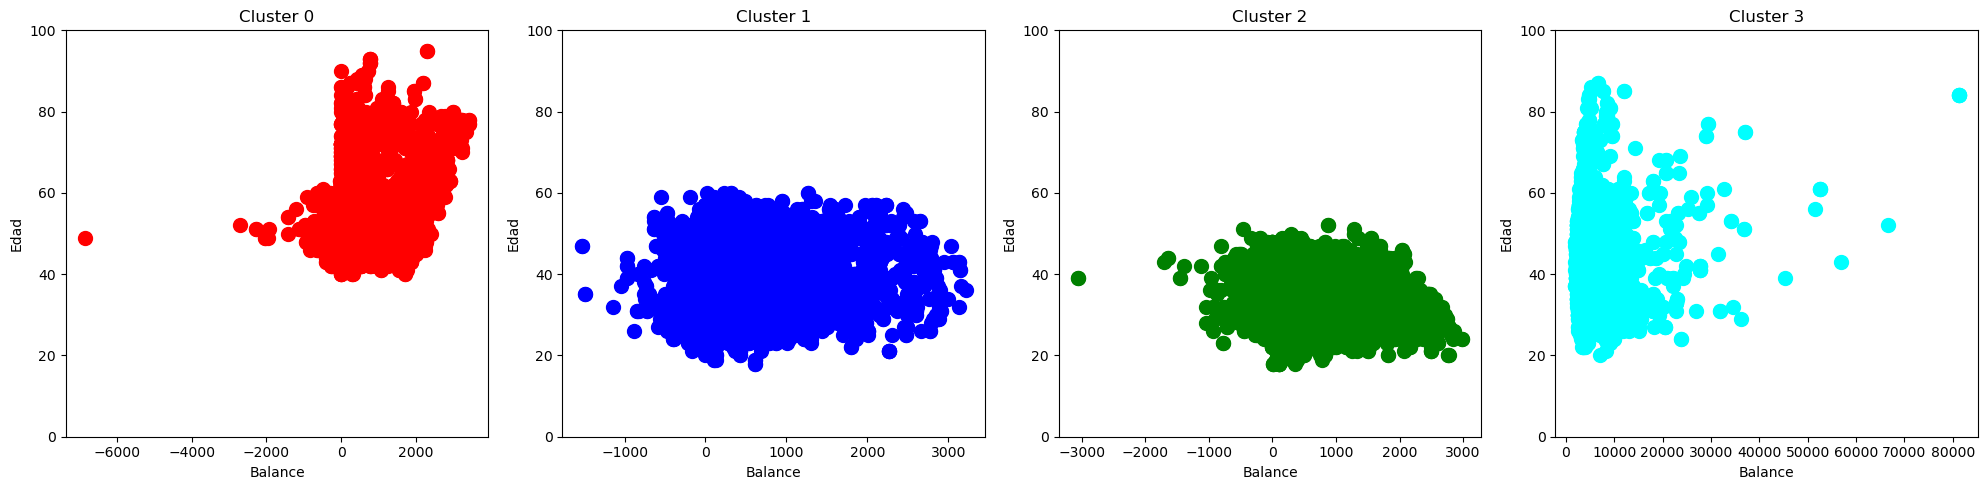

In [301]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

colors = ["red", "blue", "green", "cyan"]

for i in range(4):
    axs[i].scatter(df_results.loc[df_results["cluster"] == i, "balance"], 
                   df_results.loc[df_results["cluster"] == i, "age"], 
                   c = colors[i], s = 100)
    axs[i].set_title(f'Cluster {i}')
    axs[i].set_xlabel('Balance') 
    axs[i].set_ylabel('Edad')
    axs[i].set_ylim([0, 100])

plt.tight_layout()
plt.show()

#### Graficamos las variables categóricas

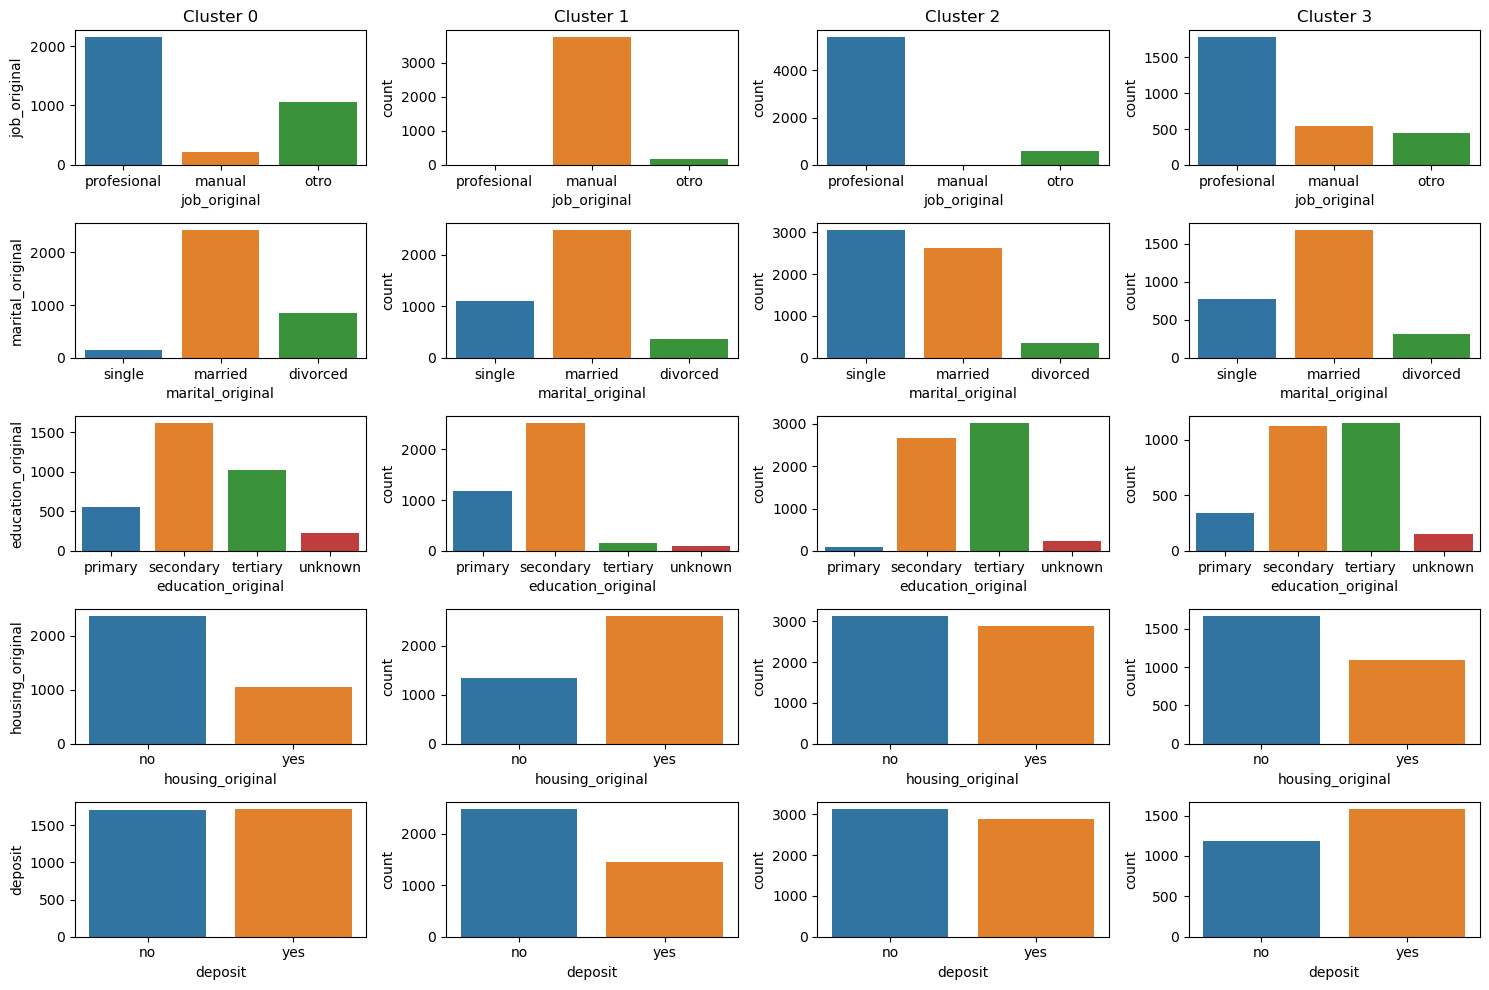

In [332]:
categorical_features = ["job_original","marital_original","education_original", "housing_original", "deposit"]

clusters = sorted(df_results['cluster'].unique())

fig, axes = plt.subplots(nrows=len(categorical_features), ncols=len(clusters), figsize=(15, 10), sharey=False)

category_orders = {
    "job_original": ["profesional", "manual", "otro"],
    "marital_original": ["single", "married", "divorced"],
    "education_original": ['primary', 'secondary', 'tertiary', 'unknown'],
    'housing_original': ['no', 'yes'],
    'deposit': ["no", "yes"]
}

for row, feature in enumerate(categorical_features):
    for col, cluster in enumerate(clusters):
        cluster_data = df_results[df_results['cluster'] == cluster]
        
        sns.countplot(data=cluster_data, x=feature, ax=axes[row, col], order=category_orders[feature])
        
        if row == 0:
            axes[row, col].set_title(f'Cluster {cluster}')
        if col == 0:
            axes[row, col].set_ylabel(feature)

plt.tight_layout()
plt.show()